# Baseline Forecasting Models

This notebook establishes baseline forecasting performance using simple statistical methods. These baselines serve as benchmarks that more sophisticated models (Prophet, SARIMAX, XGBoost) should outperform.

## Baseline Methods
1. **Naive Forecast**: Last observed value
2. **Seasonal Naive**: Same month from previous year
3. **Moving Average**: 3-month and 6-month rolling averages
4. **Linear Trend**: Simple linear regression

## Forecast Horizon
- **Training**: January 2022 - December 2024 (36 months)
- **Validation**: January 2025 - June 2025 (6 months)
- **Forecast**: July 2025 - December 2026 (18 months)

In [20]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Section 1: Load Time Series Data

Load the complete company-level time series created in notebook 08.

In [21]:
# Load company-level time series
data_path = Path('../data/processed/monthly_aggregated_full_company.parquet')

if not data_path.exists():
    # Try CSV if Parquet doesn't exist
    data_path = Path('../data/processed/monthly_aggregated_full_company.csv')
    df = pd.read_csv(data_path)
    df['date'] = pd.to_datetime(df['date'])
    df['year_month'] = pd.to_datetime(df['year_month']).dt.to_period('M')
else:
    df = pd.read_parquet(data_path)

# Sort by date
df = df.sort_values('date').reset_index(drop=True)

print(f"Loaded time series data:")
print(f"  Records: {len(df)}")
print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
print(f"  Columns: {list(df.columns)}")

Loaded time series data:
  Records: 36
  Date range: 2022-01-01 00:00:00 to 2024-12-01 00:00:00
  Columns: ['year_month', 'total_orders', 'external_drivers', 'internal_drivers', 'revenue_total', 'total_km', 'Delivery', 'Leergut', 'Pickup/Multi-leg', 'Retoure/Abholung', 'date', 'total_drivers', 'km_per_order', 'revenue_per_order', 'month', 'year']


## Section 2: Train/Validation Split

Split data for proper time series evaluation.

In [22]:
target_metrics = [
    'total_orders',
    'total_km_billed',
    'total_km_actual',
    'total_tours',
    'total_drivers',
    'revenue_total',
    'external_drivers',
    'vehicle_km_cost',      # NEW: KM-based transportation cost
    'vehicle_time_cost',    # NEW: Time-based transportation cost
    'total_vehicle_cost'    # NEW: Total vehicle operational cost
]

# Backward compatibility check
if 'total_km' in df.columns and 'total_km_billed' not in df.columns:
    target_metrics = [m.replace('total_km_billed', 'total_km') if m == 'total_km_billed' else m for m in target_metrics]
    target_metrics = [m for m in target_metrics if m != 'total_km_actual']  # Remove if not available

Data Split:
  Training: 30 months (2022-01-01 00:00:00 to 2024-06-01 00:00:00)
  Validation: 6 months (2024-07-01 00:00:00 to 2024-12-01 00:00:00)

⚠️  Note: 'total_km' exists but not renamed to 'total_km_billed' yet
    Replacing 'total_km_billed' with 'total_km' in target list

⚠️  Warning: Missing metrics in data: {'total_tours', 'total_km_actual'}
    Using available metrics: ['total_orders', 'total_km', 'total_drivers', 'revenue_total', 'external_drivers']

Target Metrics (5): ['total_orders', 'total_km', 'total_drivers', 'revenue_total', 'external_drivers']


## Section 3: Baseline Model 1 - Naive Forecast

Predict: Last observed value repeats.

In [23]:
def naive_forecast(train_data, metric, horizon):
    """
    Naive forecast: repeat last observed value.
    
    Parameters:
    -----------
    train_data : pd.DataFrame
        Training time series
    metric : str
        Target metric column name
    horizon : int
        Number of periods to forecast
    
    Returns:
    --------
    np.array
        Forecast values
    """
    last_value = train_data[metric].iloc[-1]
    return np.full(horizon, last_value)

# Generate forecasts for validation period
naive_forecasts = {}

for metric in target_metrics:
    forecast = naive_forecast(train_df, metric, len(val_df))
    naive_forecasts[metric] = forecast
    
    print(f"\nNaive Forecast - {metric}:")
    print(f"  Last training value: {train_df[metric].iloc[-1]:,.0f}")
    print(f"  Forecast (constant): {forecast[0]:,.0f}")


Naive Forecast - total_orders:
  Last training value: 130,243
  Forecast (constant): 130,243

Naive Forecast - total_km:
  Last training value: 8,055,347
  Forecast (constant): 8,055,347

Naive Forecast - total_drivers:
  Last training value: 127,948
  Forecast (constant): 127,948

Naive Forecast - revenue_total:
  Last training value: 12,051,435
  Forecast (constant): 12,051,435

Naive Forecast - external_drivers:
  Last training value: 24,386
  Forecast (constant): 24,386


## Section 4: Baseline Model 2 - Seasonal Naive

Predict: Same month from previous year.

In [24]:
def seasonal_naive_forecast(train_data, metric, horizon, seasonality=12):
    """
    Seasonal naive forecast: repeat values from same season last year.
    
    Parameters:
    -----------
    train_data : pd.DataFrame
        Training time series
    metric : str
        Target metric column name
    horizon : int
        Number of periods to forecast
    seasonality : int
        Seasonal period (12 for monthly data)
    
    Returns:
    --------
    np.array
        Forecast values
    """
    values = train_data[metric].values
    forecasts = []
    
    for i in range(horizon):
        # Get value from same month last year
        lag_idx = len(values) - seasonality + (i % seasonality)
        if lag_idx >= 0 and lag_idx < len(values):
            forecasts.append(values[lag_idx])
        else:
            # Fallback to last value if not enough history
            forecasts.append(values[-1])
    
    return np.array(forecasts)

# Generate seasonal naive forecasts
seasonal_naive_forecasts = {}

for metric in target_metrics:
    forecast = seasonal_naive_forecast(train_df, metric, len(val_df))
    seasonal_naive_forecasts[metric] = forecast
    
    print(f"\nSeasonal Naive Forecast - {metric}:")
    print(f"  Jan 2024 value: {train_df[train_df['date'] == '2024-01-01'][metric].values[0]:,.0f}")
    print(f"  Jan 2025 forecast: {forecast[0]:,.0f}")


Seasonal Naive Forecast - total_orders:
  Jan 2024 value: 132,420
  Jan 2025 forecast: 135,991

Seasonal Naive Forecast - total_km:
  Jan 2024 value: 8,354,971
  Jan 2025 forecast: 8,577,720

Seasonal Naive Forecast - total_drivers:
  Jan 2024 value: 130,180
  Jan 2025 forecast: 134,036

Seasonal Naive Forecast - revenue_total:
  Jan 2024 value: 12,961,112
  Jan 2025 forecast: 12,541,984

Seasonal Naive Forecast - external_drivers:
  Jan 2024 value: 30,450
  Jan 2025 forecast: 33,066


## Section 5: Baseline Model 3 - Moving Average

Predict: Average of last N months (N=3 and N=6).

In [25]:
def moving_average_forecast(train_data, metric, horizon, window=3):
    """
    Moving average forecast: average of last N values.
    
    Parameters:
    -----------
    train_data : pd.DataFrame
        Training time series
    metric : str
        Target metric column name
    horizon : int
        Number of periods to forecast
    window : int
        Moving average window size
    
    Returns:
    --------
    np.array
        Forecast values
    """
    values = train_data[metric].values
    ma_value = np.mean(values[-window:])
    return np.full(horizon, ma_value)

# Generate moving average forecasts (3-month and 6-month)
ma3_forecasts = {}
ma6_forecasts = {}

for metric in target_metrics:
    ma3 = moving_average_forecast(train_df, metric, len(val_df), window=3)
    ma6 = moving_average_forecast(train_df, metric, len(val_df), window=6)
    
    ma3_forecasts[metric] = ma3
    ma6_forecasts[metric] = ma6
    
    print(f"\nMoving Average Forecast - {metric}:")
    print(f"  3-month MA: {ma3[0]:,.0f}")
    print(f"  6-month MA: {ma6[0]:,.0f}")


Moving Average Forecast - total_orders:
  3-month MA: 134,286
  6-month MA: 133,523

Moving Average Forecast - total_km:
  3-month MA: 8,404,857
  6-month MA: 8,430,196

Moving Average Forecast - total_drivers:
  3-month MA: 132,189
  6-month MA: 131,409

Moving Average Forecast - revenue_total:
  3-month MA: 13,226,737
  6-month MA: 13,093,901

Moving Average Forecast - external_drivers:
  3-month MA: 27,610
  6-month MA: 28,888


## Section 6: Baseline Model 4 - Linear Trend

Predict: Extrapolate linear trend.

In [26]:
def linear_trend_forecast(train_data, metric, horizon):
    """
    Linear trend forecast: fit linear regression and extrapolate.
    
    Parameters:
    -----------
    train_data : pd.DataFrame
        Training time series
    metric : str
        Target metric column name
    horizon : int
        Number of periods to forecast
    
    Returns:
    --------
    np.array
        Forecast values
    """
    # Create time index
    X = np.arange(len(train_data)).reshape(-1, 1)
    y = train_data[metric].values
    
    # Fit linear regression
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(X, y)
    
    # Forecast
    future_X = np.arange(len(train_data), len(train_data) + horizon).reshape(-1, 1)
    forecast = model.predict(future_X)
    
    return forecast

# Generate linear trend forecasts
linear_forecasts = {}

for metric in target_metrics:
    forecast = linear_trend_forecast(train_df, metric, len(val_df))
    linear_forecasts[metric] = forecast
    
    print(f"\nLinear Trend Forecast - {metric}:")
    print(f"  Jan 2025 forecast: {forecast[0]:,.0f}")
    print(f"  Jun 2025 forecast: {forecast[-1]:,.0f}")


Linear Trend Forecast - total_orders:
  Jan 2025 forecast: 134,525
  Jun 2025 forecast: 133,878

Linear Trend Forecast - total_km:
  Jan 2025 forecast: 8,492,917
  Jun 2025 forecast: 8,453,675

Linear Trend Forecast - total_drivers:
  Jan 2025 forecast: 132,297
  Jun 2025 forecast: 131,710

Linear Trend Forecast - revenue_total:
  Jan 2025 forecast: 13,111,090
  Jun 2025 forecast: 13,196,771

Linear Trend Forecast - external_drivers:
  Jan 2025 forecast: 29,488
  Jun 2025 forecast: 28,708


In [27]:
def linear_distribution_forecast(train_data, metric, horizon):
    """
    Linear Distribution (Current Method): Previous year total ÷ 12.
    
    This represents Traveco's current forecasting approach:
    - Take previous year's total
    - Divide by 12
    - Apply same value to every month (ignores seasonality)
    
    Parameters:
    -----------
    train_data : pd.DataFrame
        Training time series
    metric : str
        Target metric column name
    horizon : int
        Number of periods to forecast
    
    Returns:
    --------
    np.array
        Forecast values (constant monthly value)
    """
    # Get last 12 months (previous full year)
    last_12_months = train_data[metric].tail(12).sum()
    
    # Divide by 12 for monthly forecast
    monthly_forecast = last_12_months / 12
    
    # Return constant value for all forecast periods
    return np.full(horizon, monthly_forecast)

# Generate linear distribution forecasts
linear_dist_forecasts = {}

print("Linear Distribution (Current Method) Forecasts:")
print("="*60)

for metric in target_metrics:
    # Calculate last 12 months total
    last_12_total = train_df[metric].tail(12).sum()
    
    forecast = linear_distribution_forecast(train_df, metric, len(val_df))
    linear_dist_forecasts[metric] = forecast
    
    print(f"\n{metric}:")
    print(f"  Previous year total (Jul 2023 - Jun 2024): {last_12_total:,.0f}")
    print(f"  Monthly forecast (total ÷ 12): {forecast[0]:,.0f}")
    print(f"  → Applied to all months (ignores seasonality)")

print("\n" + "="*60)
print("NOTE: This method ignores seasonal patterns, which is why")
print("months like February (28 days) get the same forecast as")
print("March (31 days), leading to systematic errors.")

Linear Distribution (Current Method) Forecasts:

total_orders:
  Previous year total (Jul 2023 - Jun 2024): 1,620,720
  Monthly forecast (total ÷ 12): 135,060
  → Applied to all months (ignores seasonality)

total_km:
  Previous year total (Jul 2023 - Jun 2024): 102,292,197
  Monthly forecast (total ÷ 12): 8,524,350
  → Applied to all months (ignores seasonality)

total_drivers:
  Previous year total (Jul 2023 - Jun 2024): 1,593,833
  Monthly forecast (total ÷ 12): 132,819
  → Applied to all months (ignores seasonality)

revenue_total:
  Previous year total (Jul 2023 - Jun 2024): 155,492,087
  Monthly forecast (total ÷ 12): 12,957,674
  → Applied to all months (ignores seasonality)

external_drivers:
  Previous year total (Jul 2023 - Jun 2024): 365,202
  Monthly forecast (total ÷ 12): 30,434
  → Applied to all months (ignores seasonality)

NOTE: This method ignores seasonal patterns, which is why
months like February (28 days) get the same forecast as
March (31 days), leading to system

## Section 6.5: Baseline Model 5 - Linear Distribution (Current Method)

**Traveco's Current Forecasting Approach**

Predict: Previous year total ÷ 12 = equal monthly forecast (ignores seasonality).

This represents how Traveco currently forecasts: take the yearly budget/actuals and distribute equally across 12 months.

## Section 7: Model Evaluation

Calculate MAPE, MAE, and RMSE for each baseline method.

In [28]:
def calculate_metrics(y_true, y_pred, model_name, metric_name):
    """
    Calculate forecast accuracy metrics.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    return {
        'model': model_name,
        'metric': metric_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

# Collect all results
results = []

all_forecasts = {
    'Naive': naive_forecasts,
    'Seasonal Naive': seasonal_naive_forecasts,
    'MA-3': ma3_forecasts,
    'MA-6': ma6_forecasts,
    'Linear Trend': linear_forecasts,
    'Linear Distribution (Current Method)': linear_dist_forecasts  # Added: Current method
}

for model_name, forecasts in all_forecasts.items():
    for metric in target_metrics:
        y_true = val_df[metric].values
        y_pred = forecasts[metric]
        
        metrics = calculate_metrics(y_true, y_pred, model_name, metric)
        results.append(metrics)

# Create results dataframe
results_df = pd.DataFrame(results)

print("\nBaseline Model Performance (Validation Period):")
print("="*80)
print(results_df.to_string(index=False))

# Find best model per metric
print("\n" + "="*80)
print("Best Baseline Models (by MAPE):")
print("="*80)
for metric in target_metrics:
    metric_results = results_df[results_df['metric'] == metric]
    best = metric_results.loc[metric_results['MAPE'].idxmin()]
    print(f"\n{metric}:")
    print(f"  Model: {best['model']}")
    print(f"  MAPE: {best['MAPE']:.2f}%")
    print(f"  MAE: {best['MAE']:,.0f}")

# Highlight Current Method vs Best Model
print("\n" + "="*80)
print("CURRENT METHOD vs BEST MODEL COMPARISON:")
print("="*80)
for metric in target_metrics:
    metric_results = results_df[results_df['metric'] == metric]
    best = metric_results.loc[metric_results['MAPE'].idxmin()]
    current = metric_results[metric_results['model'] == 'Linear Distribution (Current Method)'].iloc[0]
    
    improvement = ((current['MAPE'] - best['MAPE']) / current['MAPE']) * 100
    
    print(f"\n{metric}:")
    print(f"  Current Method MAPE: {current['MAPE']:.2f}%")
    print(f"  Best Model ({best['model']}) MAPE: {best['MAPE']:.2f}%")
    print(f"  → Improvement: {improvement:.1f}% error reduction")


Baseline Model Performance (Validation Period):
                               model           metric          MAE         RMSE      MAPE
                               Naive     total_orders 9.696167e+03 1.110902e+04  6.789117
                               Naive         total_km 6.516438e+05 7.343308e+05  7.344219
                               Naive    total_drivers 9.586833e+03 1.091155e+04  6.836859
                               Naive    revenue_total 1.244668e+06 1.443802e+06  9.096475
                               Naive external_drivers 3.250500e+03 3.584311e+03 11.484800
                      Seasonal Naive     total_orders 4.179000e+03 5.239557e+03  2.942918
                      Seasonal Naive         total_km 2.528738e+05 2.879283e+05  2.889437
                      Seasonal Naive    total_drivers 3.975333e+03 5.160233e+03  2.845968
                      Seasonal Naive    revenue_total 6.203381e+05 7.246928e+05  4.589851
                      Seasonal Naive external_drive

## Section 8: Visualization

Plot actual vs forecasted values for each baseline method.

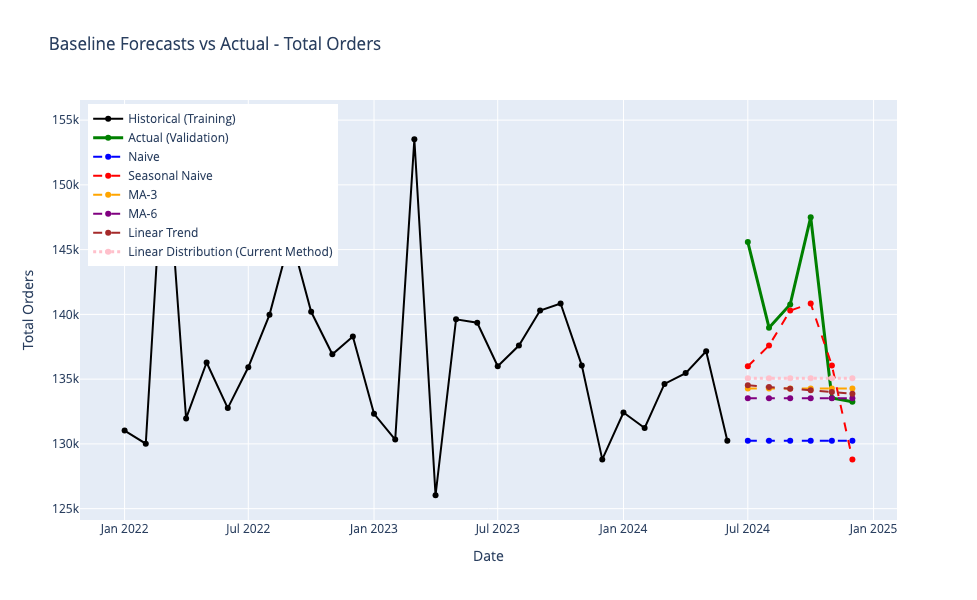


✓ Saved chart: results/baseline_forecasts_total_orders.html


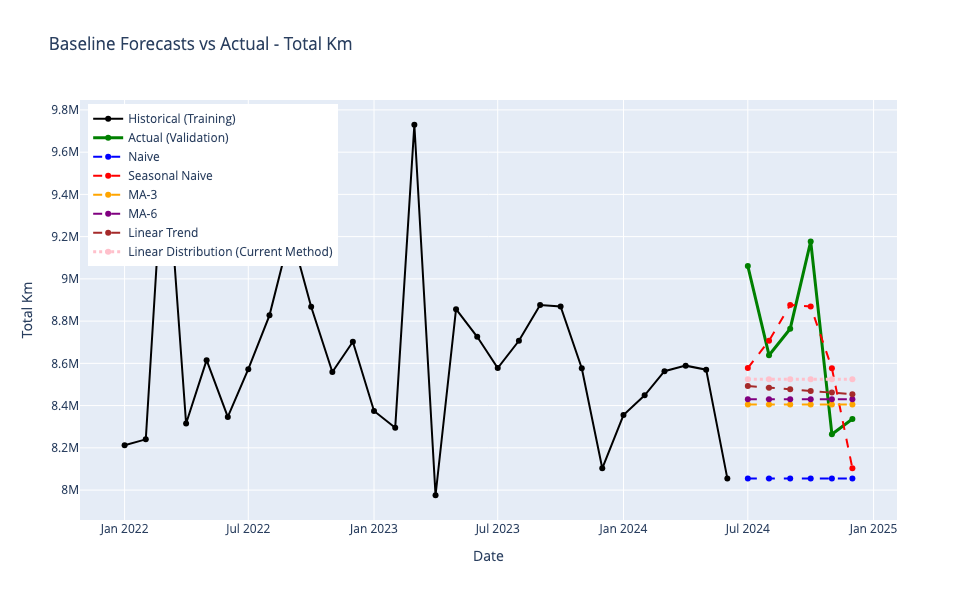


✓ Saved chart: results/baseline_forecasts_total_km.html


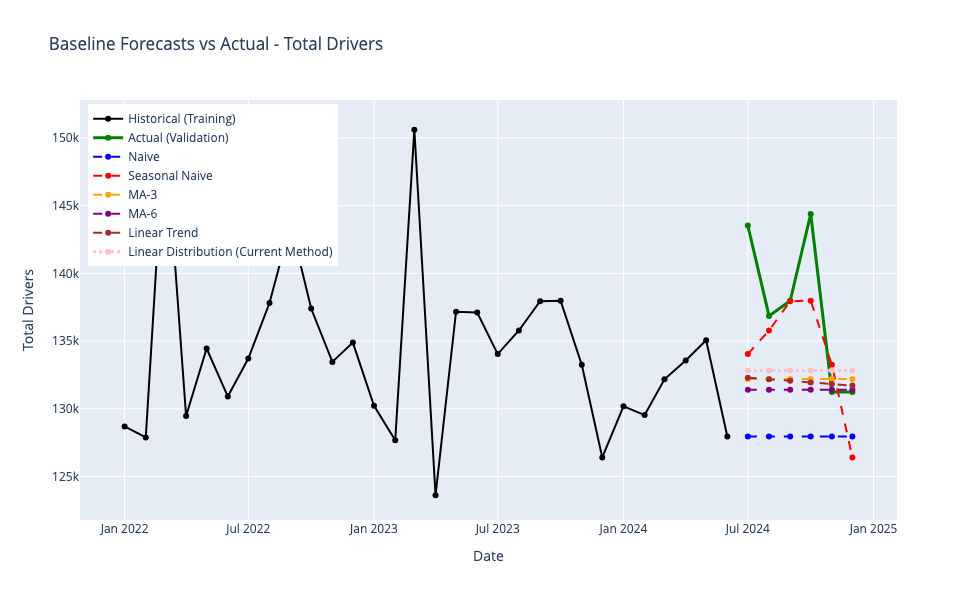


✓ Saved chart: results/baseline_forecasts_total_drivers.html


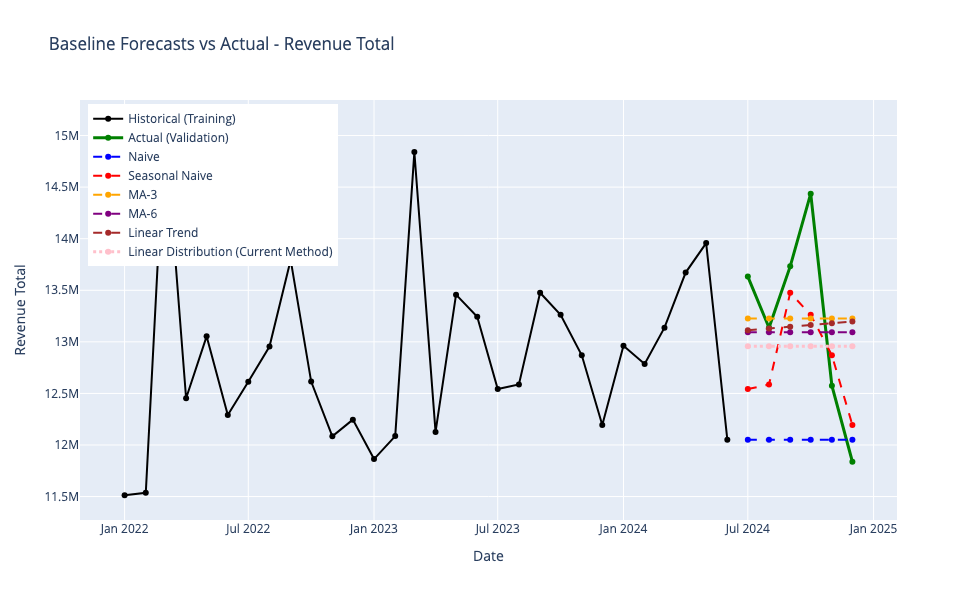


✓ Saved chart: results/baseline_forecasts_revenue_total.html


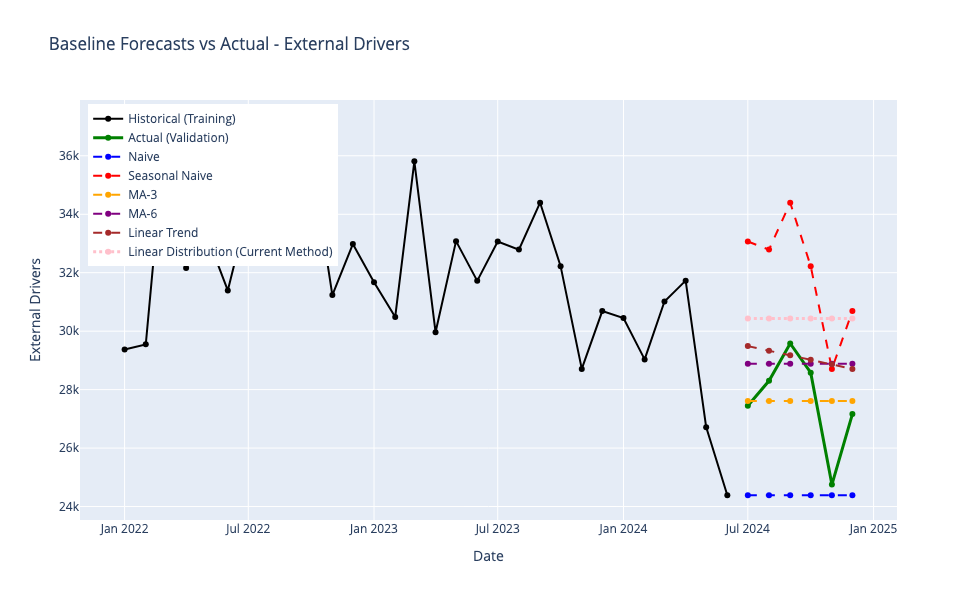


✓ Saved chart: results/baseline_forecasts_external_drivers.html


In [29]:
# Create comparison charts for each metric
for metric in target_metrics:
    fig = go.Figure()
    
    # Historical data (training)
    fig.add_trace(
        go.Scatter(
            x=train_df['date'],
            y=train_df[metric],
            mode='lines+markers',
            name='Historical (Training)',
            line=dict(color='black', width=2)
        )
    )
    
    # Actual validation values
    fig.add_trace(
        go.Scatter(
            x=val_df['date'],
            y=val_df[metric],
            mode='lines+markers',
            name='Actual (Validation)',
            line=dict(color='green', width=3)
        )
    )
    
    # Baseline forecasts
    colors = ['blue', 'red', 'orange', 'purple', 'brown', 'pink']
    for i, (model_name, forecasts) in enumerate(all_forecasts.items()):
        # Highlight Current Method with different line style
        line_style = dict(color=colors[i], width=3 if 'Current Method' in model_name else 2, 
                          dash='dot' if 'Current Method' in model_name else 'dash')
        
        fig.add_trace(
            go.Scatter(
                x=val_df['date'],
                y=forecasts[metric],
                mode='lines+markers',
                name=model_name,
                line=line_style
            )
        )
    
    fig.update_layout(
        title=f"Baseline Forecasts vs Actual - {metric.replace('_', ' ').title()}",
        xaxis_title="Date",
        yaxis_title=metric.replace('_', ' ').title(),
        height=600,
        hovermode='x unified',
        legend=dict(x=0.01, y=0.99)
    )
    
    fig.show()
    
    # Save to results
    results_dir = Path('../results')
    results_dir.mkdir(exist_ok=True)
    fig.write_html(results_dir / f'baseline_forecasts_{metric}.html')
    print(f"\n✓ Saved chart: results/baseline_forecasts_{metric}.html")

## Section 9: Save Results

Save baseline forecasts and performance metrics for comparison in notebook 15.

In [30]:
# Save performance metrics
output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True)

results_df.to_csv(output_dir / 'baseline_metrics.csv', index=False)
print(f"✓ Saved baseline metrics to: data/processed/baseline_metrics.csv")

# Save forecasts for each method
for model_name, forecasts in all_forecasts.items():
    forecast_df = pd.DataFrame({
        'date': val_df['date'],
        'year_month': val_df['year_month'].astype(str),
    })
    
    for metric in target_metrics:
        forecast_df[metric] = forecasts[metric]
    
    filename = f"baseline_forecast_{model_name.lower().replace(' ', '_').replace('-', '').replace('(', '').replace(')', '')}.csv"
    forecast_df.to_csv(output_dir / filename, index=False)
    print(f"✓ Saved {model_name} forecasts to: data/processed/{filename}")

print(f"\n{'='*80}")
print(f"BASELINE MODELS COMPLETE!")
print(f"{'='*80}")
print(f"\nKey Findings:")
print(f"  • {len(all_forecasts)} baseline methods evaluated (including Current Method)")
print(f"  • {len(target_metrics)} target metrics forecasted")
print(f"  • Validation period: {len(val_df)} months (Jul-Dec 2024)")
print(f"\nCurrent Method Performance:")
current_results = results_df[results_df['model'] == 'Linear Distribution (Current Method)']
for metric in target_metrics:
    mape = current_results[current_results['metric'] == metric]['MAPE'].values[0]
    print(f"  • {metric}: {mape:.2f}% MAPE")
print(f"\nThese baselines establish the performance threshold that")
print(f"advanced models (Prophet, SARIMAX, XGBoost) should exceed.")
print(f"\nNext: Run notebooks 10-12 for advanced forecasting models, then")
print(f"notebook 16 for Current Method vs Seasonal Naive comparison.")

✓ Saved baseline metrics to: data/processed/baseline_metrics.csv
✓ Saved Naive forecasts to: data/processed/baseline_forecast_naive.csv
✓ Saved Seasonal Naive forecasts to: data/processed/baseline_forecast_seasonal_naive.csv
✓ Saved MA-3 forecasts to: data/processed/baseline_forecast_ma3.csv
✓ Saved MA-6 forecasts to: data/processed/baseline_forecast_ma6.csv
✓ Saved Linear Trend forecasts to: data/processed/baseline_forecast_linear_trend.csv
✓ Saved Linear Distribution (Current Method) forecasts to: data/processed/baseline_forecast_linear_distribution_current_method.csv

BASELINE MODELS COMPLETE!

Key Findings:
  • 6 baseline methods evaluated (including Current Method)
  • 5 target metrics forecasted
  • Validation period: 6 months (Jul-Dec 2024)

Current Method Performance:
  • total_orders: 4.17% MAPE
  • total_km: 3.75% MAPE
  • total_drivers: 4.09% MAPE
  • revenue_total: 5.78% MAPE
  • external_drivers: 10.47% MAPE

These baselines establish the performance threshold that
advance